In [1]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name

conf = (SparkConf().setMaster("k8s://https://192.168.219.100:6443") # Your master address name
        .set("spark.kubernetes.container.image", "joron1827/pyspark:latest") # Spark image name
        .set("spark.driver.port", "2222") # Needs to match svc
        .set("spark.driver.blockManager.port", "7777")
        .set("spark.driver.host", "driver-service.jupyterhub.svc.cluster.local") # Needs to match svc
        .set("spark.driver.bindAddress", "0.0.0.0")
        .set("spark.kubernetes.namespace", "spark")
        .set("spark.kubernetes.authenticate.driver.serviceAccountName", "spark")
        .set("spark.kubernetes.authenticate.serviceAccountName", "spark")
        .set("spark.executor.instances", "3")
        .set("spark.kubernetes.container.image.pullPolicy", "IfNotPresent")
        .set("spark.app.name", "joronSpark")
        .set("spark.executor.cores", "2")
        .set("spark.executor.memory", "8g"))

In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [3]:
df = spark.read.option("header", "true").option("encoding", "cp949").csv("hdfs://192.168.219.121:9000/stock/*.csv")


In [4]:
from pyspark.sql.functions import input_file_name
# input_file_name() 함수를 사용하여 현재 처리 중인 파일의 경로를 얻음
df = df.withColumn("file_path", input_file_name())

In [5]:
df = df.withColumn("stock_code", df["file_path"].substr(36, 6))

In [6]:
df.show()

+--------+------+------+------+------+------+--------------------+----------+
|    날짜|  시가|  고가|  저가|  종가|거래량|           file_path|stock_code|
+--------+------+------+------+------+------+--------------------+----------+
|20230428|611000|626000|588000|623000|118337|hdfs://192.168.21...|    051900|
|20230428|611000|626000|588000|623000|118337|hdfs://192.168.21...|    051900|
|20230427|612000|628000|607000|618000| 68793|hdfs://192.168.21...|    051900|
|20230426|609000|627000|604000|617000| 44660|hdfs://192.168.21...|    051900|
|20230425|621000|625000|605000|609000| 42695|hdfs://192.168.21...|    051900|
|20230424|607000|626000|596000|625000|106426|hdfs://192.168.21...|    051900|
|20230421|654000|655000|608000|610000|153598|hdfs://192.168.21...|    051900|
|20230420|675000|680000|660000|664000| 42461|hdfs://192.168.21...|    051900|
|20230419|684000|691000|669000|674000| 78565|hdfs://192.168.21...|    051900|
|20230418|637000|687000|637000|680000|117121|hdfs://192.168.21...|    051900|

In [7]:
## 파일 경로 열 삭제하기

df = df.drop('file_path')
df.show()

+--------+------+------+------+------+------+----------+
|    날짜|  시가|  고가|  저가|  종가|거래량|stock_code|
+--------+------+------+------+------+------+----------+
|20230428|611000|626000|588000|623000|118337|    051900|
|20230428|611000|626000|588000|623000|118337|    051900|
|20230427|612000|628000|607000|618000| 68793|    051900|
|20230426|609000|627000|604000|617000| 44660|    051900|
|20230425|621000|625000|605000|609000| 42695|    051900|
|20230424|607000|626000|596000|625000|106426|    051900|
|20230421|654000|655000|608000|610000|153598|    051900|
|20230420|675000|680000|660000|664000| 42461|    051900|
|20230419|684000|691000|669000|674000| 78565|    051900|
|20230418|637000|687000|637000|680000|117121|    051900|
|20230417|651000|657000|642000|647000| 46648|    051900|
|20230414|650000|661000|641000|652000| 59008|    051900|
|20230413|651000|663000|641000|643000| 63317|    051900|
|20230412|641000|652000|635000|650000| 68365|    051900|
|20230411|626000|657000|612000|646000|137785

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, col

# 종목(stock_code)과 날짜(날짜)를 기준으로 윈도우 함수 설정
window = Window.partitionBy("stock_code", "날짜").orderBy("날짜")

# 중복된 행에 대해 row_number() 함수를 사용하여 행 번호 부여
df = df.withColumn("row_num", row_number().over(window))

# row_num이 1인 행을 제외한 나머지 중복 행 제거
df = df.filter(col("row_num") == 1).drop("row_num")
df.show()

+--------+----+----+----+----+------+----------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|
+--------+----+----+----+----+------+----------+
|20170613|8930|9090|8900|9040|138036|    000020|
|20170626|8610|8630|8520|8590| 38738|    000020|
|20170628|8480|8480|8350|8350| 65937|    000020|
|20170629|8340|8440|8330|8410| 47668|    000020|
|20170630|8450|8540|8410|8470| 48558|    000020|
|20170705|8430|8440|8300|8340| 62841|    000020|
|20170706|8340|8420|8300|8400| 48957|    000020|
|20170728|8360|8360|8160|8180| 89526|    000020|
|20170801|8180|8260|8110|8200| 59629|    000020|
|20170818|8530|8720|8530|8710|115578|    000020|
|20170828|8840|8980|8840|8910| 91634|    000020|
|20170905|8810|8850|8670|8710|108670|    000020|
|20170907|8710|8880|8710|8870| 87084|    000020|
|20170912|8950|8990|8850|8910| 66985|    000020|
|20170922|8840|8950|8560|8640|135843|    000020|
|20170929|8600|8620|8550|8560| 15105|    000020|
|20171013|8930|9080|8860|8970|113322|    000020|
|20171025|9270|9280|9170|9210| 65

In [10]:

# 날짜와 종목 코드로 정렬
df = df.orderBy(col("stock_code"),col("날짜"))
df.show()

+--------+----+----+----+----+------+----------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|
+--------+----+----+----+----+------+----------+
|20170601|9010|9040|8840|8940| 89610|    000020|
|20170602|8940|9020|8870|9000| 90581|    000020|
|20170605|8990|9240|8970|9140|177175|    000020|
|20170607|9150|9160|8990|9090|108208|    000020|
|20170608|9080|9210|8970|9130|255999|    000020|
|20170609|9140|9180|9000|9050|124202|    000020|
|20170612|9020|9080|8870|8870| 72203|    000020|
|20170613|8930|9090|8900|9040|138036|    000020|
|20170614|9080|9080|8960|8960| 97462|    000020|
|20170615|8970|8980|8770|8810|173542|    000020|
|20170616|8840|8840|8590|8680|158720|    000020|
|20170619|8690|8720|8630|8680| 63186|    000020|
|20170620|8700|8700|8360|8450|213907|    000020|
|20170621|8450|8600|8410|8600| 95160|    000020|
|20170622|8600|8630|8520|8580| 70449|    000020|
|20170623|8550|8660|8540|8630|110692|    000020|
|20170626|8610|8630|8520|8590| 38738|    000020|
|20170627|8590|8590|8470|8490| 64

In [11]:
from pyspark.sql.functions import lag, col, when, avg
from pyspark.sql.window import Window

# RSI 계산을 위한 변수 설정
window_size = 14

# 차이 계산을 위한 컬럼 추가
df_rsi = df.withColumn("close_diff", col("종가") - lag("종가").over(Window.partitionBy("stock_code").orderBy("날짜")))

# 상승 및 하락에 따른 값을 설정하는 컬럼 추가
df_rsi = df_rsi.withColumn("gain", when(col("close_diff") > 0, col("close_diff")).otherwise(0))
df_rsi = df_rsi.withColumn("loss", when(col("close_diff") < 0, -col("close_diff")).otherwise(0))

# 이동 평균 계산을 위한 윈도우 설정
rsi_window = Window.partitionBy("stock_code").orderBy("날짜").rowsBetween(-window_size, -1)

# 이동 평균 계산
df_rsi = df_rsi.withColumn("avg_gain", avg(col("gain")).over(rsi_window))
df_rsi = df_rsi.withColumn("avg_loss", avg(col("loss")).over(rsi_window))

# RSI 계산
rsi = col("avg_gain") / (col("avg_gain") + col("avg_loss")) * 100
df_rsi = df_rsi.withColumn("RSI", when(col("avg_loss") == 0, 100).otherwise(when(col("avg_gain") == 0, 0).otherwise(rsi)))

# 새로운 DataFrame에 저장된 RSI 결과 확인
df_rsi.show()


+--------+----+----+----+----+------+----------+----------+-----+-----+------------------+------------------+------------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|close_diff| gain| loss|          avg_gain|          avg_loss|               RSI|
+--------+----+----+----+----+------+----------+----------+-----+-----+------------------+------------------+------------------+
|20170601|9010|9040|8840|8940| 89610|    000020|      null|  0.0|  0.0|              null|              null|              null|
|20170602|8940|9020|8870|9000| 90581|    000020|      60.0| 60.0|  0.0|               0.0|               0.0|             100.0|
|20170605|8990|9240|8970|9140|177175|    000020|     140.0|140.0|  0.0|              30.0|               0.0|             100.0|
|20170607|9150|9160|8990|9090|108208|    000020|     -50.0|  0.0| 50.0| 66.66666666666667|               0.0|             100.0|
|20170608|9080|9210|8970|9130|255999|    000020|      40.0| 40.0|  0.0|              50.0|              12.5| 

/tmp/ipykernel_3963/330851531.py:28: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_3963/330851531.py:28: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_3963/330851531.py:28: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_3963/330851531.py:28: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_3963/330851531.py:28: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_3963/330851531.py:28: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  plt.tight_layout()  # 차트 요소들의 간격 조정
/tmp/ipykernel_3963/330851531.py:28: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE T

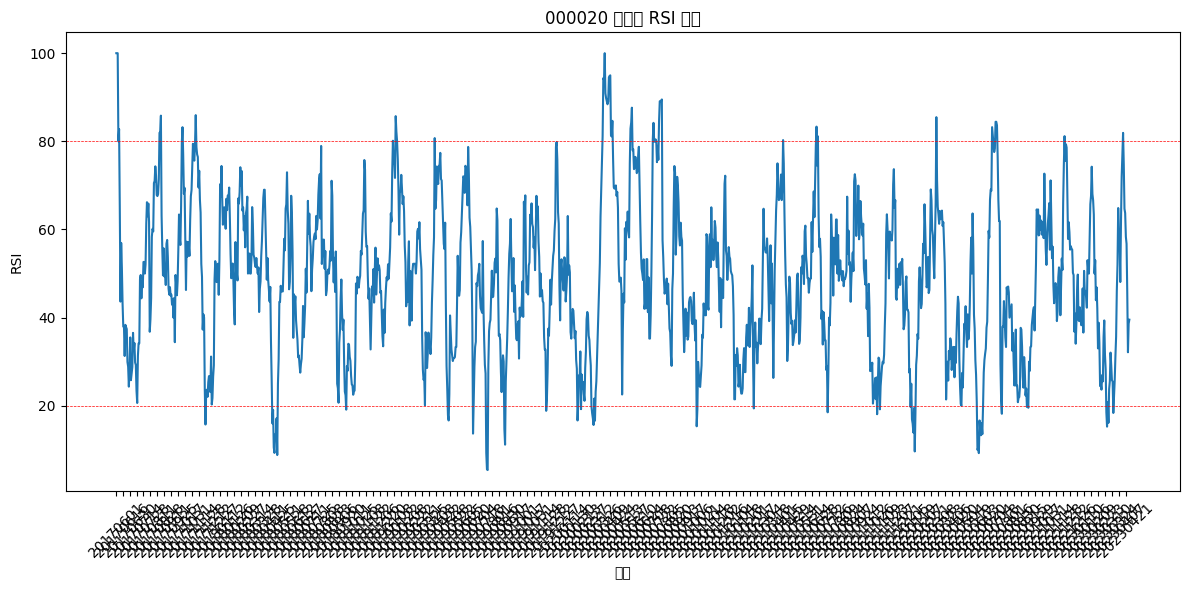

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 선택할 종목 코드
selected_stock_code = "000020"

# 특정 종목 코드에 대한 RSI 값 추출
selected_rsi_df = df_rsi.filter(df_rsi.stock_code == selected_stock_code)
dates = selected_rsi_df.select("날짜").rdd.flatMap(lambda x: x).collect()
rsi_values = selected_rsi_df.select("RSI").rdd.flatMap(lambda x: x).collect()

# RSI 차트 그리기
plt.figure(figsize=(12, 6))  # 차트 크기 조정
plt.plot(rsi_values)
plt.ylabel("RSI")
plt.title(f"{selected_stock_code} 종목의 RSI 차트")

# RSI 20 이하와 80 이상인 가로줄 추가
plt.axhline(y=20, color='r', linestyle='--', linewidth=0.5)  # RSI 20 이하 가로줄
plt.axhline(y=80, color='r', linestyle='--', linewidth=0.5)  # RSI 80 이상 가로줄

# x축 설정
x_ticks = np.arange(0, len(dates), 10)  # 10일 주기로 눈금 표시
x_labels = [dates[i] for i in x_ticks]
plt.xticks(x_ticks, x_labels, rotation=45)
plt.xlabel("날짜")

plt.tight_layout()  # 차트 요소들의 간격 조정
plt.show()


In [13]:
from pyspark.sql.functions import avg
from pyspark.sql.window import Window

# 이동평균선을 계산할 기간 설정
short_term = 5
medium_term = 20
long_term = 60

# 각 기간에 대한 컬럼 이름 설정
short_term_col = f"이동평균_{short_term}일"
medium_term_col = f"이동평균_{medium_term}일"
long_term_col = f"이동평균_{long_term}일"

# 종목(stock_code)별로 윈도우 함수 설정
window = Window.partitionBy("stock_code").orderBy("날짜")

# 각 종목별로 이동평균선 계산하여 새로운 컬럼 추가
df_ma = df_rsi.withColumn(short_term_col, avg("종가").over(window.rowsBetween(-(short_term-1), 0))) \
              .withColumn(medium_term_col, avg("종가").over(window.rowsBetween(-(medium_term-1), 0))) \
              .withColumn(long_term_col, avg("종가").over(window.rowsBetween(-(long_term-1), 0)))

# 결과 확인
df_ma.show()



+--------+----+----+----+----+------+----------+----------+-----+-----+------------------+------------------+------------------+-----------------+-----------------+-----------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|close_diff| gain| loss|          avg_gain|          avg_loss|               RSI|     이동평균_5일|    이동평균_20일|    이동평균_60일|
+--------+----+----+----+----+------+----------+----------+-----+-----+------------------+------------------+------------------+-----------------+-----------------+-----------------+
|20170601|9010|9040|8840|8940| 89610|    000020|      null|  0.0|  0.0|              null|              null|              null|           8940.0|           8940.0|           8940.0|
|20170602|8940|9020|8870|9000| 90581|    000020|      60.0| 60.0|  0.0|               0.0|               0.0|             100.0|           8970.0|           8970.0|           8970.0|
|20170605|8990|9240|8970|9140|177175|    000020|     140.0|140.0|  0.0|              30.0|               0.0|    

In [20]:
from pyspark.sql.functions import lag, lead, col

# local minimum과 local maximum을 구하기 위한 조건식 설정
min_conditions = [(col(f"{col_name}") < lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") < lead(col(f"{col_name}")).over(window))
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local minimum과 local maximum을 구하기 위한 조건식 설정
max_conditions = [(col(f"{col_name}") > lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") > lead(col(f"{col_name}")).over(window))
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local minimum과 local maximum을 나타내는 열 추가
df_extrema = df_ma.withColumn("Local_Minimum_5일", when(min_conditions[0], col(short_term_col)).otherwise(None)) \
                  .withColumn("Local_Maximum_5일", when(max_conditions[0], col(short_term_col)).otherwise(None)) \
                  .withColumn("Local_Minimum_20일", when(min_conditions[1], col(medium_term_col)).otherwise(None)) \
                  .withColumn("Local_Maximum_20일", when(max_conditions[1], col(medium_term_col)).otherwise(None)) \
                  .withColumn("Local_Minimum_60일", when(min_conditions[2], col(long_term_col)).otherwise(None)) \
                  .withColumn("Local_Maximum_60일", when(max_conditions[2], col(long_term_col)).otherwise(None))

# 결과 확인
df_extrema.show()



+--------+----+----+----+----+------+----------+----------+-----+-----+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|close_diff| gain| loss|          avg_gain|          avg_loss|               RSI|     이동평균_5일|    이동평균_20일|    이동평균_60일|Local_Minimum_5일|Local_Maximum_5일|Local_Minimum_20일|Local_Maximum_20일|Local_Minimum_60일|Local_Maximum_60일|
+--------+----+----+----+----+------+----------+----------+-----+-----+------------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|20170601|9010|9040|8840|8940| 89610|    000020|      null|  0.0|  0.0|              null|              null|              null|           8940.0|   

In [42]:
columns_to_drop = ["close_diff","gain","loss","avg_gain","avg_loss"]
df_extrema = df_extrema.drop(*columns_to_drop)
df_extrema.show()

+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|               RSI|     이동평균_5일|    이동평균_20일|    이동평균_60일|Local_Minimum_5일|Local_Maximum_5일|Local_Minimum_20일|Local_Maximum_20일|Local_Minimum_60일|Local_Maximum_60일|
+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|20170601|9010|9040|8840|8940| 89610|    000020|              null|           8940.0|           8940.0|           8940.0|             null|             null|              null|              null|              null|              null|
|20170602|8940|9020|8870|9000| 90581|    000020|             100.0|           8970.0|           89

/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44536 (\N{HANGUL SYLLABLE GEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54532 (\N{HANGUL SYLLABLE PEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.9/site-packages/IPytho

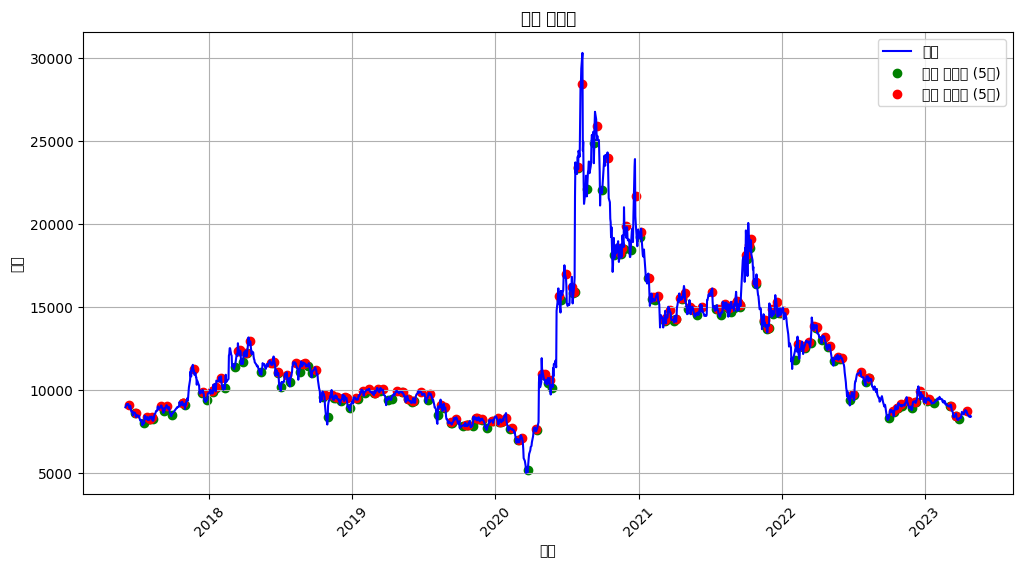

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 데이터 프레임을 판다스 DataFrame으로 변환
df_pd = df_extrema.filter(df_extrema.stock_code == "000020").select("날짜", "종가", "Local_Minimum_5일", "Local_Maximum_5일").toPandas()

# 날짜 형식 변환
df_pd['날짜'] = pd.to_datetime(df_pd['날짜'], format='%Y%m%d')

import numpy as np

# 비어있는 날짜에 NaN 할당
df_pd['종가'] = df_pd['종가'].astype(float)  # 종가 열의 데이터 타입을 float으로 변환
df_pd['종가'] = df_pd['종가'].replace(0, np.nan)  # 종가 열에서 0 값을 NaN으로 대체

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(df_pd['날짜'], df_pd['종가'], label='종가', color='blue')
plt.scatter(df_pd['날짜'], df_pd['Local_Minimum_5일'], marker='o', color='green', label='로컬 최소값 (5일)')
plt.scatter(df_pd['날짜'], df_pd['Local_Maximum_5일'], marker='o', color='red', label='로컬 최대값 (5일)')
plt.xticks(rotation=45)
plt.xlabel('날짜')
plt.ylabel('종가')
plt.title('종가 그래프')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
from pyspark.sql.functions import col, lag, when
from pyspark.sql.window import Window

# 일주일 후 상승/하락 컬럼 추가
window = Window.partitionBy("stock_code").orderBy("날짜")
df_extrema = df_extrema.withColumn("일주일_후_상승", when((col("종가") / lag(col("종가")).over(window)) >= 1.05, 1).otherwise(0))
df_extrema = df_extrema.withColumn("일주일_후_하락", when((col("종가") / lag(col("종가")).over(window)) <= 0.95, 1).otherwise(0))

# 한 달 후 상승/하락 컬럼 추가
df_extrema = df_extrema.withColumn("한달_후_상승", when((col("종가") / lag(col("종가"), 20).over(window)) >= 1.05, 1).otherwise(0))
df_extrema = df_extrema.withColumn("한달_후_하락", when((col("종가") / lag(col("종가"), 20).over(window)) <= 0.95, 1).otherwise(0))


In [69]:
df_extrema.show()

+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------+--------------+------------+------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|               RSI|     이동평균_5일|    이동평균_20일|    이동평균_60일|Local_Minimum_5일|Local_Maximum_5일|Local_Minimum_20일|Local_Maximum_20일|Local_Minimum_60일|Local_Maximum_60일|일주일_후_상승|일주일_후_하락|한달_후_상승|한달_후_하락|
+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------+--------------+------------+------------+
|20170601|9010|9040|8840|8940| 89610|    000020|              null|           8940.0|           8940.0|           8940.0|             null|             null|              null|          

In [74]:
from pyspark.sql.functions import lag, lead, col

# local maximum을 구하는 조건식 설정
conditions = [(col(f"{col_name}") > lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") > lead(col(f"{col_name}")).over(window)) &
              (col("RSI") >= 80)
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local maximum을 나타내는 열 추가
df_extrema = df_extrema.withColumn("Local_Maximum_5일_RSI80", when(conditions[0], col(short_term_col)).otherwise(None)) \
                       .withColumn("Local_Maximum_20일_RSI80", when(conditions[1], col(medium_term_col)).otherwise(None)) \
                       .withColumn("Local_Maximum_60일_RSI80", when(conditions[2], col(long_term_col)).otherwise(None))

# 결과 확인
df_extrema.show()

+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------+--------------+------------+------------+-----------------------+------------------------+------------------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|               RSI|     이동평균_5일|    이동평균_20일|    이동평균_60일|Local_Minimum_5일|Local_Maximum_5일|Local_Minimum_20일|Local_Maximum_20일|Local_Minimum_60일|Local_Maximum_60일|일주일_후_상승|일주일_후_하락|한달_후_상승|한달_후_하락|Local_Maximum_5일_RSI80|Local_Maximum_20일_RSI80|Local_Maximum_60일_RSI80|
+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------+--------------+------------+------------+-----------------------+------------------

In [75]:
from pyspark.sql.functions import lag, lead, col

# local minimum을 구하는 조건식 설정
conditions = [(col(f"{col_name}") < lag(col(f"{col_name}")).over(window)) &
              (col(f"{col_name}") < lead(col(f"{col_name}")).over(window)) &
              (col("RSI") <= 20)
              for col_name in [short_term_col, medium_term_col, long_term_col]]

# local minimum을 나타내는 열 추가
df_extrema = df_extrema.withColumn("Local_Minimum_5일_RSI20", when(conditions[0], col(short_term_col)).otherwise(None)) \
                       .withColumn("Local_Minimum_20일_RSI20", when(conditions[1], col(medium_term_col)).otherwise(None)) \
                       .withColumn("Local_Minimum_60일_RSI20", when(conditions[2], col(long_term_col)).otherwise(None))

# 결과 확인
df_extrema.show()

23/05/30 08:36:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+--------------+--------------+------------+------------+-----------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|               RSI|     이동평균_5일|    이동평균_20일|    이동평균_60일|Local_Minimum_5일|Local_Maximum_5일|Local_Minimum_20일|Local_Maximum_20일|Local_Minimum_60일|Local_Maximum_60일|일주일_후_상승|일주일_후_하락|한달_후_상승|한달_후_하락|Local_Maximum_5일_RSI80|Local_Maximum_20일_RSI80|Local_Maximum_60일_RSI80|Local_Minimum_5일_RSI20|Local_Minimum_20일_RSI20|Local_Minimum_60일_RSI20|
+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+----------

In [76]:
columns_to_drop = ["Local_Minimum_5일","Local_Maximum_5일","Local_Minimum_20일","Local_Maximum_20일","Local_Minimum_60일","Local_Maximum_60일"]
df_extrema = df_extrema.drop(*columns_to_drop)
df_extrema.show()

+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+--------------+--------------+------------+------------+-----------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+
|    날짜|시가|고가|저가|종가|거래량|stock_code|               RSI|     이동평균_5일|    이동평균_20일|    이동평균_60일|일주일_후_상승|일주일_후_하락|한달_후_상승|한달_후_하락|Local_Maximum_5일_RSI80|Local_Maximum_20일_RSI80|Local_Maximum_60일_RSI80|Local_Minimum_5일_RSI20|Local_Minimum_20일_RSI20|Local_Minimum_60일_RSI20|
+--------+----+----+----+----+------+----------+------------------+-----------------+-----------------+-----------------+--------------+--------------+------------+------------+-----------------------+------------------------+------------------------+-----------------------+------------------------+------------------------+
|20170601|9010|9040|8840|8940| 89610|    000020|              null|           

In [78]:
from pyspark.sql.functions import expr

# 한달 후 상승이 1인 값의 개수 구하기
df_extrema.createOrReplaceTempView("extrema_table")

query = """
SELECT stock_code, COUNT(*) AS `한달_후_상승_개수`
FROM extrema_table
WHERE `Local_Minimum_5일_RSI20` IS NOT NULL AND `한달_후_상승` = 1
GROUP BY stock_code
"""

result = spark.sql(query)

# 결과 확인
result.show()

+----------+-----------------+
|stock_code|한달_후_상승_개수|
+----------+-----------------+
|    000220|                1|
|    002900|                1|
|    004830|                1|
|    008420|                1|
|    009070|                1|
|    009460|                1|
|    010820|                1|
|    016880|                1|
|    069730|                1|
|    088350|                1|
|    26490K|                1|
|    002995|                1|
|    004770|                1|
|    004835|                1|
|    006345|                1|
|    006370|                1|
|    041650|                1|
|    001290|                1|
|    002787|                1|
|    003495|                1|
+----------+-----------------+
only showing top 20 rows



In [77]:
from pyspark.sql.functions import expr

# 한달 후 하락이 1인 값의 개수 구하기
df_extrema.createOrReplaceTempView("extrema_table")

query = """
SELECT stock_code, COUNT(*) AS `한달_후_하락_개수`
FROM extrema_table
WHERE `Local_Maximum_5일_RSI80` IS NOT NULL AND `한달_후_하락` = 1
GROUP BY stock_code
"""

result = spark.sql(query)

# 결과 확인
result.show()

+----------+-----------------+
|stock_code|한달_후_하락_개수|
+----------+-----------------+
|    017810|                1|
|    001527|                1|
|    001755|                1|
|    018500|                1|
|    111110|                1|
|    004060|                1|
|    015590|                1|
|    077500|                1|
|    097520|                1|
|    004540|                1|
|    105840|                1|
|    001620|                1|
|    093370|                1|
|    023960|                1|
|    073240|                1|
+----------+-----------------+

